In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import sys
import os
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer, TargetEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import spmatrix
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score
import re
sys.path.append(os.path.abspath("../"))
from src.data.load_data import load_dataset
sys.path.append(os.path.abspath("../src")) 
from src.features.preprocess import deterministic_fe
from src.utils.helpers import other_titles,get_personal_title
from src.features.transformers import PersonalTitleTransformer
from src.features.pipe_config import preprocessing_pipeline
from src.utils.helpers import grid_search_res
from joblib import dump
%load_ext autoreload
%autoreload 2

In [1]:
train = load_dataset('../data/raw/train.csv')
test = load_dataset('../data/raw/test.csv')
X_train = train.drop('Survived', axis=1)
y_train = train['Survived']
X_test = test.drop('Survived', axis=1)
y_test = test['Survived']

NameError: name 'load_dataset' is not defined

In [ ]:
rf_model = Pipeline([
    ('preprocess', preprocessing_pipeline()),
    ('model', RandomForestClassifier(random_state = 42))
])

In [25]:
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv = cross_validate(rf_model,
                     scoring=scoring, cv=skf,
                    X= X_train,
                    y = y_train, 
                    return_train_score = True)


In [26]:
pd.DataFrame(cv).mean()#.to_excel('../reports/model_outputs/train/rf_clf/base_rf_model.xlsx')

fit_time                    5.477748
score_time                  0.451174
test_accuracy               0.849512
train_accuracy              0.959918
test_precision_weighted     0.849276
train_precision_weighted    0.960539
test_recall_weighted        0.849512
train_recall_weighted       0.959918
test_f1_weighted            0.848250
train_f1_weighted           0.959649
dtype: float64

In [ ]:
param_grid = {
    'model__n_estimators':[100,300,500],
    'model__max_depth':[5,10,20,None],
    'model__min_samples_split':[2,5,10],
    'model__class_weight':[None,'balanced'],
    'model__ccp_alpha' :[0,0.001,0.01]
}
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'f1': 'f1_weighted',
}
gs = GridSearchCV(rf_model, param_grid, scoring = scoring, cv=5, return_train_score=True, refit='f1',verbose=2, n_jobs=-1)

In [43]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END model__ccp_alpha=0, model__class_weight=None, model__max_depth=5, model__min_samples_split=2, model__n_estimators=100; total time=   0.1s
[CV] END model__ccp_alpha=0, model__class_weight=None, model__max_depth=5, model__min_samples_split=2, model__n_estimators=100; total time=   0.1s
[CV] END model__ccp_alpha=0, model__class_weight=None, model__max_depth=5, model__min_samples_split=2, model__n_estimators=100; total time=   0.1s
[CV] END model__ccp_alpha=0, model__class_weight=None, model__max_depth=5, model__min_samples_split=2, model__n_estimators=100; total time=   0.1s
[CV] END model__ccp_alpha=0, model__class_weight=None, model__max_depth=5, model__min_samples_split=2, model__n_estimators=100; total time=   0.1s
[CV] END model__ccp_alpha=0, model__class_weight=None, model__max_depth=5, model__min_samples_split=2, model__n_estimators=300; total time=   0.3s
[CV] END model__ccp_alpha=0, model__class_weight=None,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        Pipeline(steps=[('Deterministic_fe',
                                                         FunctionTransformer(func=<function deterministic_fe at 0x16a8a7a60>)),
                                                        ('personal_title',
                                                         PersonalTitleTransformer()),
                                                        ('encode',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False...
                                                               random_state=42))]),
             param_grid={'model__ccp_alpha': [0, 0.001, 0.01],
                         'model__class_weight': [None, 'balanced'],
                         'model__max_depth': [5, 10, 20, None],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [100, 300, 500]},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'f1': 'f1_weighted',
                      'precision': 'precision_weighted',
                      'recall': 'recall_weighted'},
             verbose=2)

In [ ]:
res = pd.DataFrame(gs.cv_results_)

res[res['mean_test_f1']==max(res['mean_test_f1'])].T



128       137
mean_fit_time           0.323776  0.324808
std_fit_time            0.006146  0.006926
mean_score_time         0.034583  0.034607
std_score_time          0.001008  0.001395
param_model__ccp_alpha     0.001     0.001
...                          ...       ...
split2_train_f1         0.962858  0.962858
split3_train_f1         0.955783  0.955783
split4_train_f1         0.966499  0.966499
mean_train_f1             0.9636    0.9636
std_train_f1            0.005342  0.005342

[70 rows x 2 columns]

In [53]:
gs.best_params_

{'model__ccp_alpha': 0.001,
 'model__class_weight': 'balanced',
 'model__max_depth': 20,
 'model__min_samples_split': 2,
 'model__n_estimators': 500}

After initial grid search i will optimize the n_estimators parameter
best params 

{'model__ccp_alpha': 0.001,
 'model__class_weight': 'balanced',
 'model__max_depth': 20,
 'model__min_samples_split': 2,
 'model__n_estimators': 500}

In [20]:
scores = []


for n_estimators in np.arange(100,2000, 100):
    i = 1
    pipe = Pipeline([
        ('preprocess', preprocessing_pipeline()),
        ('model', RandomForestClassifier(random_state=42,
                                         n_estimators=n_estimators, 
                                         class_weight='balanced', 
                                         max_depth=20,
                                         min_samples_split=2,
                                         ccp_alpha=0.001, 
                                         oob_score=True,
                                         n_jobs=-1))
    ])

    pipe.fit(X_train, y_train)
    scores.append(pipe.named_steps['model'].oob_score_)
    print(f'In iteration {i} checked {n_estimators}')
    i+=1
    




In iteration 1 checked 100
In iteration 1 checked 200
In iteration 1 checked 300
In iteration 1 checked 400
In iteration 1 checked 500
In iteration 1 checked 600
In iteration 1 checked 700
In iteration 1 checked 800
In iteration 1 checked 900
In iteration 1 checked 1000
In iteration 1 checked 1100
In iteration 1 checked 1200
In iteration 1 checked 1300
In iteration 1 checked 1400
In iteration 1 checked 1500
In iteration 1 checked 1600
In iteration 1 checked 1700
In iteration 1 checked 1800
In iteration 1 checked 1900


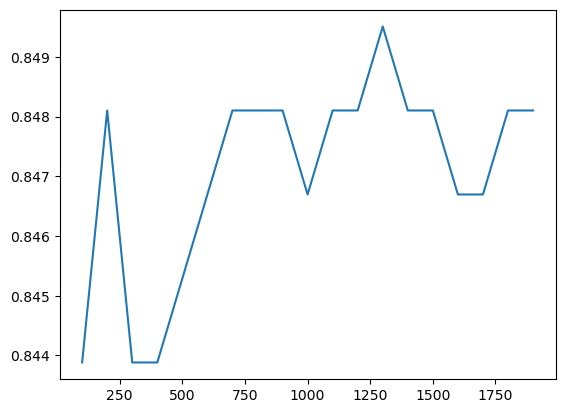

In [21]:
plt.plot(np.arange(100,2000, 100), scores)

There is no point in large amount of trees. The model is stable already with 500 models

n_estimators set to 500. Now looking through more narrow param grid for final model

In [ ]:
{'model__ccp_alpha': 0.001,
 'model__class_weight': 'balanced',
 'model__max_depth': 20,
 'model__min_samples_split': 2,
 'model__n_estimators': 500}

In [ ]:
rf_model = Pipeline([
    ('preprocess', preprocessing_pipeline()),
    ('model', RandomForestClassifier(random_state = 42,
                                     class_weight='balanced',
                                     n_estimators=500))
])

In [29]:
param_grid = {
    'model__max_depth':np.arange(10,20,1),
    'model__min_samples_split':[2,3,4,5],
    'model__ccp_alpha' :np.linspace(0.01, 0.001,10),
    'model__min_samples_leaf':[1,2,5,10],
    'model__max_features':['sqrt',0.9,0.8]

}
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'f1': 'f1_weighted',
}
gs = GridSearchCV(rf_model, param_grid, scoring = scoring, cv=5, return_train_score=True, refit='f1',verbose=2, n_jobs=-1)

In [30]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 4800 candidates, totalling 24000 fits
[CV] END model__ccp_alpha=0.01, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2; total time=   0.5s
[CV] END model__ccp_alpha=0.01, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=3; total time=   0.5s
[CV] END model__ccp_alpha=0.01, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2; total time=   0.6s
[CV] END model__ccp_alpha=0.01, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=3; total time=   0.6s
[CV] END model__ccp_alpha=0.01, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2; total time=   0.5s
[CV] END model__ccp_alpha=0.01, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=4; total time=   0.6s
[CV] END model__

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        Pipeline(steps=[('Deterministic_fe',
                                                         FunctionTransformer(func=<function deterministic_fe at 0x17a82d3a0>)),
                                                        ('personal_title',
                                                         PersonalTitleTransformer()),
                                                        ('encode',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False...
             param_grid={'model__ccp_alpha': array([0.01 , 0.009, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002,
       0.001]),
                         'model__max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                         'model__max_features': ['sqrt', 0.9, 0.8],
                         'model__min_samples_leaf': [1, 2, 5, 10],
                         'model__min_samples_split': [2, 3, 4, 5]},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'f1': 'f1_weighted',
                      'precision': 'precision_weighted',
                      'recall': 'recall_weighted'},
             verbose=2)

In [31]:
gs.best_params_

{'model__ccp_alpha': np.float64(0.003),
 'model__max_depth': np.int64(13),
 'model__max_features': 0.9,
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 5}

In [45]:
large_gs_res = pd.DataFrame(gs.cv_results_)
large_gs_res[large_gs_res['mean_test_f1'] == max(large_gs_res['mean_test_f1'])].T.to_excel('../reports/model_outputs/train/rf_clf/best_gs.xlsx')
#Mean test f1 = 0.8531
#Mean train f1 = 0.9163

              precision    recall  f1-score   support

           0       0.83      0.80      0.81       109
           1       0.70      0.74      0.72        69

    accuracy                           0.78       178
   macro avg       0.76      0.77      0.77       178
weighted avg       0.78      0.78      0.78       178



<bound method Pipeline.get_params of Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('Deterministic_fe',
                                  FunctionTransformer(func=<function deterministic_fe at 0x17a82d3a0>)),
                                 ('personal_title', PersonalTitleTransformer()),
                                 ('encode',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False),
                                                                   ['Embarked',
                                                                    'Personal_titl...
                           

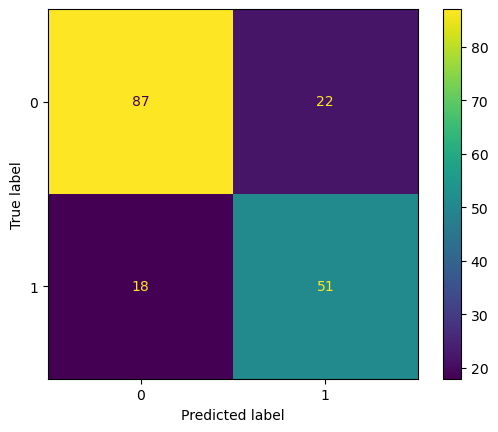

In [49]:
best_rf = gs.best_estimator_
best_rf.fit(X_train, y_train)
preds = best_rf.predict(X_test)
print(classification_report(y_test, preds))
ConfusionMatrixDisplay.from_predictions(y_test, preds)

dump(best_rf,'../src/dumped_models/best_rf_model.pkl')

best_rf.get_params

In [ ]:
feat_imps = best_rf.feature